# Image Selection (aka Masking)

Examples of mask usage

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from astroviper.distributed.image_analysis.selection import select_mask, apply_select

In [2]:
rng = np.random.default_rng(42)
ny, nx = 128, 160
y, x = np.mgrid[0:ny, 0:nx]
img = 0.1 + np.exp(-((x - nx / 2) ** 2) / (2 * 12.0 ** 2) - ((y - ny / 2) ** 2) / (2 * 8.0 ** 2))
# img = img + 0.05 * rng.normal(size=img.shape)
da = xr.DataArray(img, dims=("y", "x"), coords={"y": np.arange(ny), "x": np.arange(nx)}, name="intensity")

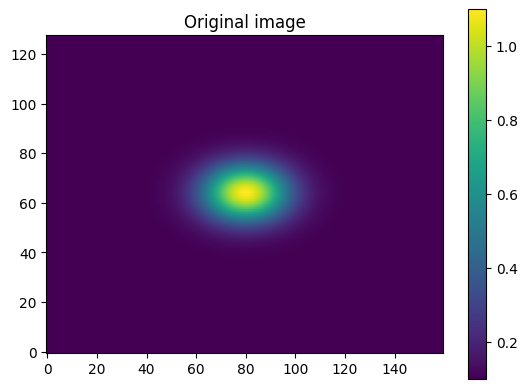

In [3]:
fig, ax = plt.subplots()
im = ax.imshow(da, origin="lower")
ax.set_title("Original image")
fig.colorbar(im, ax=ax)
plt.show()

## 1) `select=None` → use everything

mask_all dtype: bool true count: 20480


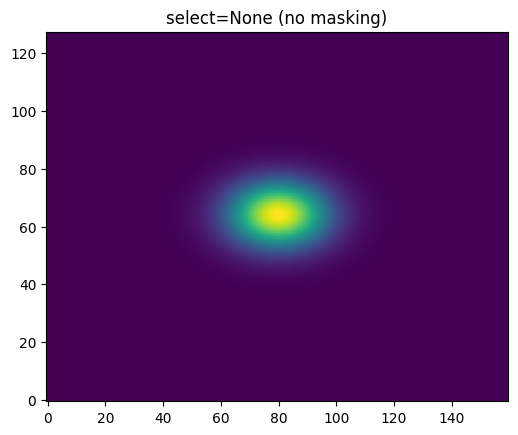

In [4]:
# creates an all True (nothing masked) selection/mask
mask_all = select_mask(da, select=None)
# apply that selection, everything is selected
sel_all = apply_select(da, select=None)

print("mask_all dtype:", mask_all.dtype, "true count:", int(mask_all.values.sum()))

fig, ax = plt.subplots()
ax.imshow(sel_all, origin="lower")
ax.set_title("select=None (no masking)")
plt.show()


## 2) Boolean array-like (DataArray or ndarray)
Create a circular region of interest (ROI) mask and apply it.

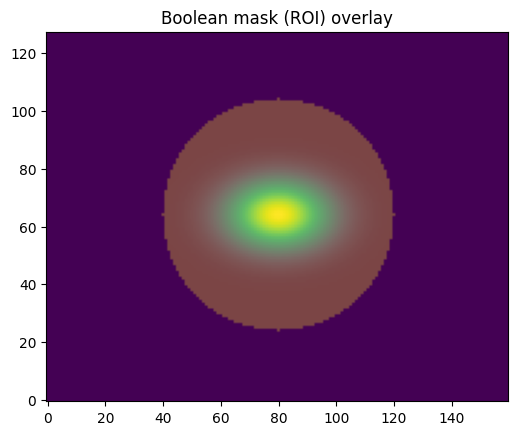

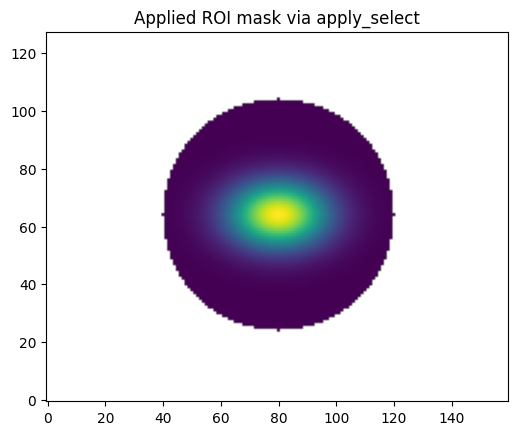

In [5]:
cy, cx = ny / 2, nx / 2
r = min(ny, nx) / 3.2  # why: focus on core region
roi = ((y - cy) ** 2 + (x - cx) ** 2) <= (r ** 2)
roi_da = xr.DataArray(roi, dims=("y", "x"), coords=da.coords, name="roi")

mask_roi = select_mask(da, select=roi_da)
sel_roi = apply_select(da, select=roi_da)

fig, ax = plt.subplots()
ax.imshow(da, origin="lower")
ax.imshow(mask_roi, origin="lower", alpha=0.3)
ax.set_title("Boolean mask (ROI) overlay")
plt.show()

fig, ax = plt.subplots()
ax.imshow(sel_roi, origin="lower")
ax.set_title("Applied ROI mask via apply_select")
plt.show()

## 3) String expression over named masks ("roi & ~bad & ~sidelobe")
Build masks and a `mask_source` mapping and use an expression.

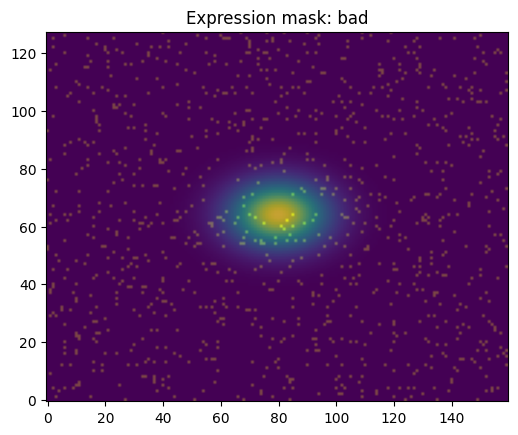

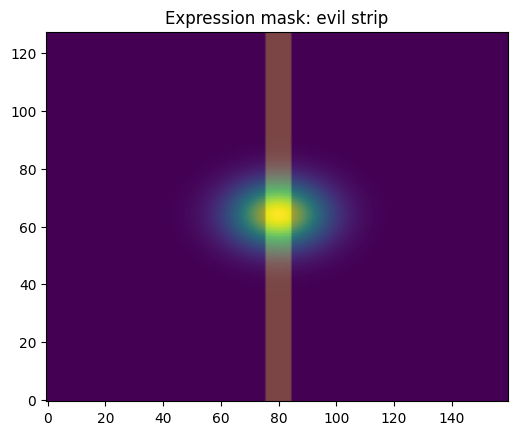

expr true count: 4095 of 20480


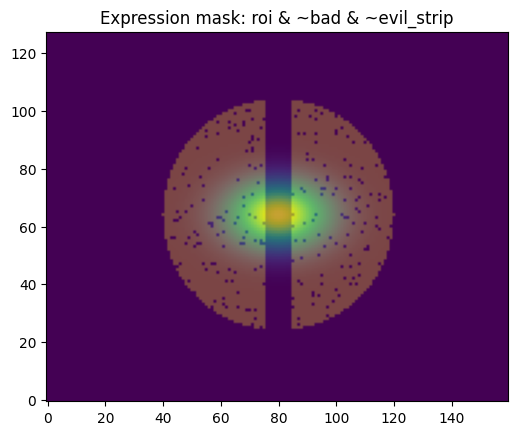

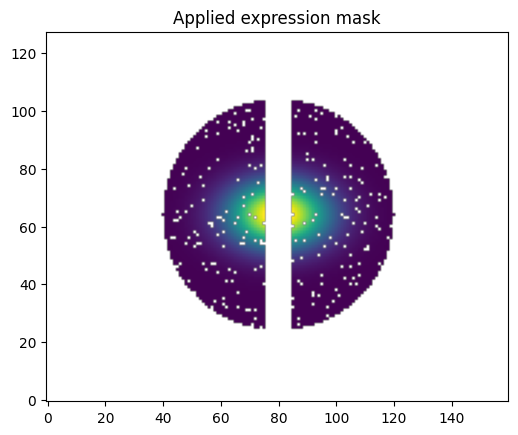

In [6]:
# bad: random speckles; sidelobe: thin frame near edges (why: emulate flagged pixels)

bad = rng.random((ny, nx)) < 0.05

expr = "bad"
fig, ax = plt.subplots()
ax.imshow(da, origin="lower")
ax.imshow(bad, origin="lower", alpha=0.3)
ax.set_title(f"Expression mask: {expr}")
plt.show()


# sidelobe = (x < 5) | (x > nx - 6) | (y < 5) | (y > ny - 6)

evil_strip = (x > nx/2 - 5) & (x < nx/2 +5) 

expr = "evil strip"
fig, ax = plt.subplots()
ax.imshow(da, origin="lower")
ax.imshow(evil_strip, origin="lower", alpha=0.3)
ax.set_title(f"Expression mask: {expr}")
plt.show()


mask_source = {
    "roi": roi_da,                                 # keep xarray to preserve coords
    "bad": xr.DataArray(bad, dims=("y", "x"), coords=da.coords),
    "evil_strip": xr.DataArray(evil_strip, dims=("y", "x"), coords=da.coords),
}

expr = "roi & ~bad & ~evil_strip"
# expr = "roi & ~sidelobe"

mask_expr = select_mask(da, select=expr, mask_source=mask_source)
sel_expr = apply_select(da, select=expr, mask_source=mask_source)

print(
    "expr true count:", int(mask_expr.values.sum()),
    "of", mask_expr.size,
)

fig, ax = plt.subplots()
ax.imshow(da, origin="lower")
ax.imshow(mask_expr, origin="lower", alpha=0.3)
ax.set_title(f"Expression mask: {expr}")
plt.show()

fig, ax = plt.subplots()
ax.imshow(sel_expr, origin="lower")
ax.set_title("Applied expression mask")
plt.show()


## Data: simple image with a bright blob

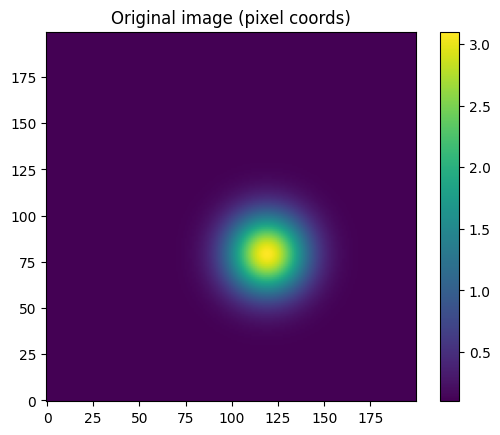

In [7]:
ny = nx = 200
x = np.arange(1, nx + 1)  # pixel centers 1..nx
y = np.arange(1, ny + 1)  # pixel centers 1..ny
X, Y = np.meshgrid(x, y)
Z = 0.1 + 3.0 * np.exp(-((X - 120) ** 2 + (Y - 80) ** 2) / (2 * 15 ** 2))
da = xr.DataArray(Z, dims=("y", "x"), coords={"x": x, "y": y}, name="intensity")

fig, ax = plt.subplots()
im = ax.imshow(da, origin="lower")
ax.set_title("Original image (pixel coords)")
fig.colorbar(im, ax=ax)
plt.show()

### Utility to overlay masks

In [63]:
def show_mask(ax, data: xr.DataArray, mask: xr.DataArray, title: str):
    # base image
    ax.imshow(data, origin="lower", interpolation="none")
    # dim the outside region
    ax.imshow(~mask, origin="lower", interpolation="none", alpha=0.18)
    # highlight the kept region
    ax.imshow(np.ma.masked_where(~mask, data), origin="lower", interpolation="none", alpha=0.85)
    # draw a crisp boundary
    ax.contour(mask, levels=[0.5], colors="k", linewidths=1.2, origin="lower")
    ax.set_title(title)
"""
def show_mask(ax, data: xr.DataArray, mask: xr.DataArray, title: str):
    ax.imshow(data, origin="lower")
    ax.imshow(mask, origin="lower", alpha=0.3)
    ax.set_title(title)
"""

'\ndef show_mask(ax, data: xr.DataArray, mask: xr.DataArray, title: str):\n    ax.imshow(data, origin="lower")\n    ax.imshow(mask, origin="lower", alpha=0.3)\n    ax.set_title(title)\n'

## 1) Box region
CRTF header is optional — both forms are supported.

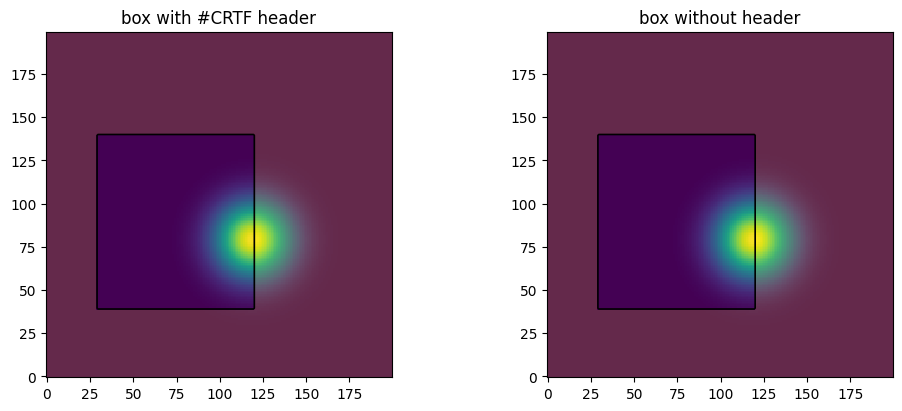

In [64]:
crtf_with_header = """
#CRTF
box[[ 30, 40 ], [ 120, 140 ]]
""".strip()

crtf_no_header = "box[[30,40],[120,140]]"

mask1 = select_mask(da, select=crtf_with_header)
mask1b = select_mask(da, select=crtf_no_header)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
show_mask(ax1, da, mask1, "box with #CRTF header")
show_mask(ax2, da, mask1b, "box without header")
plt.show()

selected pixel count: 8012
masked mean (finite only): 0.33603289425511407


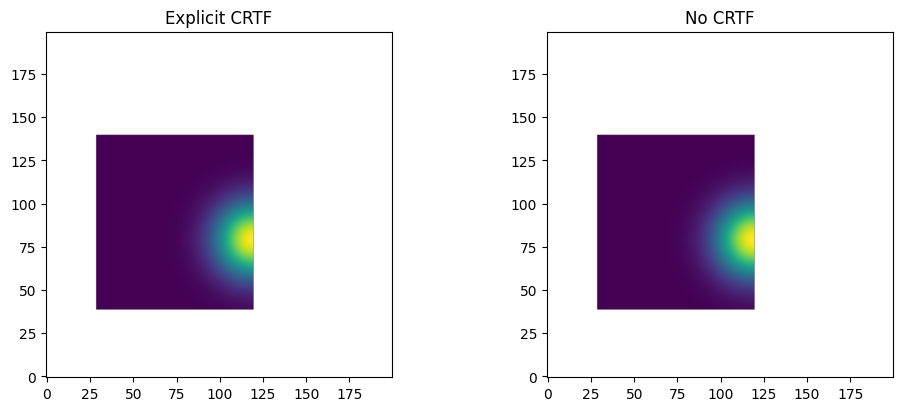

In [76]:
sel = apply_select(da, select=mask1)
selb = apply_select(da, select=mask1b)

print("selected pixel count:", int(select_mask(da, select=multi).values.sum()))
print("masked mean (finite only):", float(np.nanmean(sel)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
ax1.imshow(sel, origin="lower")
ax2.imshow(selb, origin="lower")
ax1.set_title("Explicit CRTF")
ax2.set_title("No CRTF")
plt.show()

## 2) Rotated box (rotbox)
Syntax: `rotbox[[cx,cy],[width,height], angle]`; angle in `deg` or `rad` (default = deg).

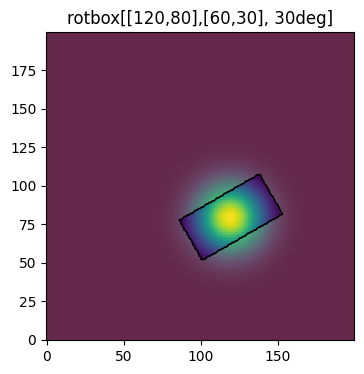

In [35]:
rot = "rotbox[[120,80],[60,30], 30deg]"
mask_rot = select_mask(da, select=rot)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, da, mask_rot, rot)
plt.show()

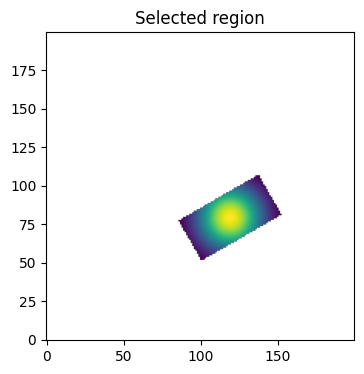

In [77]:
sel = apply_select(da, select=mask_rot)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel, origin="lower")
ax.set_title("Selected region")
plt.show()

## 3) Circle and annulus

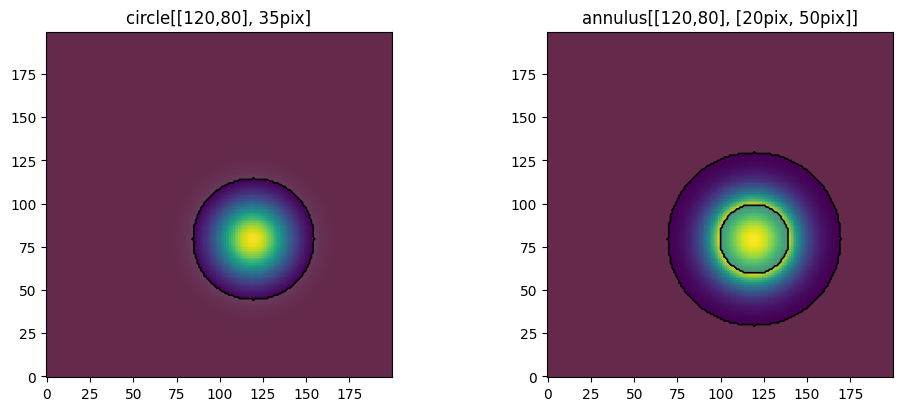

In [36]:
circle = "circle[[120,80], 35pix]"
annulus = "annulus[[120,80], [20pix, 50pix]]"
mask_circle = select_mask(da, select=circle)
mask_ann = select_mask(da, select=annulus)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
show_mask(ax1, da, mask_circle, circle)
show_mask(ax2, da, mask_ann, annulus)
plt.show()

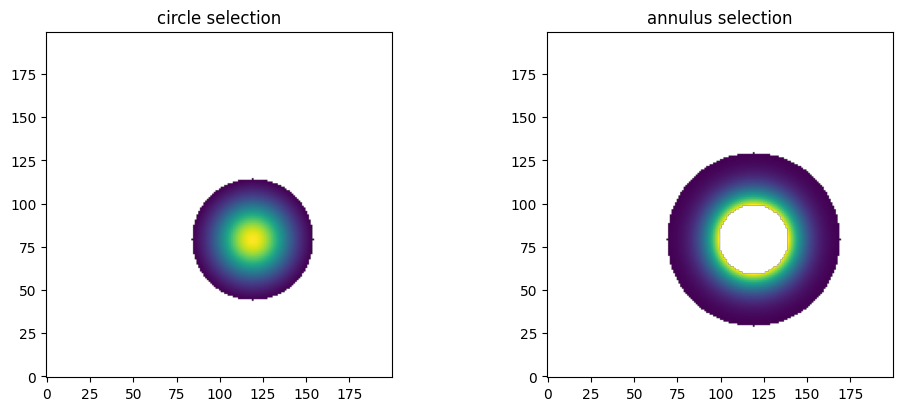

In [79]:
sel_circle = apply_select(da, select=mask_circle)
sel_ann = apply_select(da, select=mask_ann)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
ax1.imshow(sel_circle, origin="lower")
ax2.imshow(sel_ann, origin="lower")
ax1.set_title("circle selection")
ax2.set_title("annulus selection")
plt.show()

## 4) Ellipse with position angle
Format: `ellipse[[cx,cy], [a,b], pa]` where `a`, `b` are **semi-axes in pixels**.

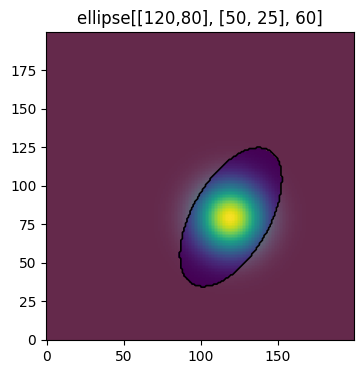

In [37]:
ellipse = "ellipse[[120,80], [50, 25], 60]"  # 60 degrees
mask_ellipse = select_mask(da, select=ellipse)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, da, mask_ellipse, ellipse)
plt.show()

## 5) Polygon (poly)

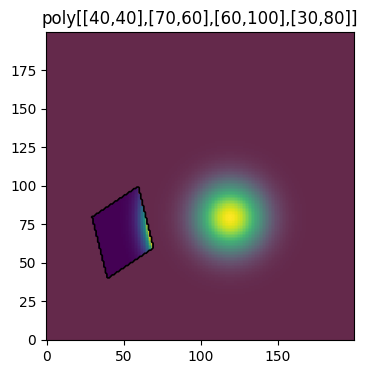

In [38]:
poly = "poly[[40,40],[70,60],[60,100],[30,80]]"
mask_poly = select_mask(da, select=poly)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, da, mask_poly, poly)
plt.show()

## 6) Multiple CRTF lines with `+` (OR) and `-` (subtract)
Lines are combined; default is `+` if no prefix.

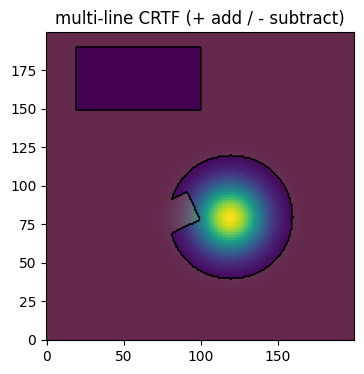

In [54]:
multi = """
#CRTF
+circle[[120,80], 40]
-rotbox[[80,80],[35,20], 25deg]
+box[[20,150],[100,190]]
""".strip()

mask_multi = select_mask(da, select=multi)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, da, mask_multi, "multi-line CRTF (+ add / - subtract)")
plt.show()

## 7) Apply selection to the image and compute simple stats

selected pixel count: 8012
masked mean (finite only): 0.5994905171890875


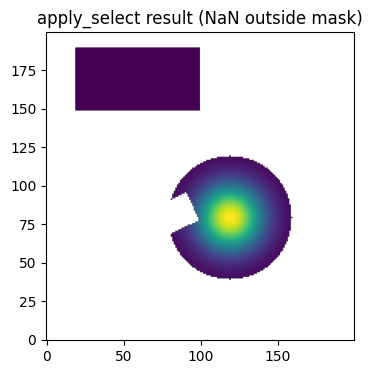

In [55]:
sel = apply_select(da, select=multi)

print("selected pixel count:", int(select_mask(da, select=multi).values.sum()))
print("masked mean (finite only):", float(np.nanmean(sel)))

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel, origin="lower")
ax.set_title("apply_select result (NaN outside mask)")
plt.show()

## 8) Mixing CRTF with named-mask expressions
If the string **is not** detected as CRTF, it is treated as a named-mask expression.
Example uses `roi & ~bad` combining masks provided in a mapping or dataset.

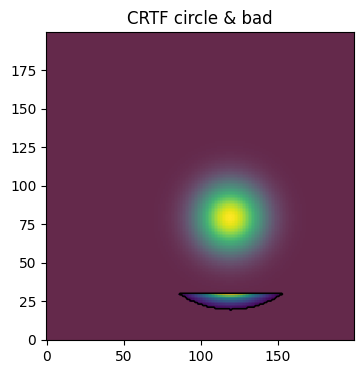

In [41]:
roi = select_mask(da, select="circle[[120,80], 60]")
edge = select_mask(da, select="box[[1,1],[200,30]]") | select_mask(da, select="box[[1,1],[30,200]]")
mask_source = {"roi": roi, "bad": edge}
expr = "roi & bad"
mask_expr = select_mask(da, select=expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, da, mask_expr, "CRTF circle & bad")
plt.show()


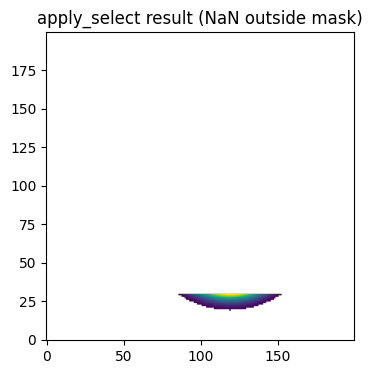

In [42]:
sel_expr = apply_select(da, select=mask_expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel_expr, origin="lower")
ax.set_title("apply_select result (NaN outside mask)")
plt.show()

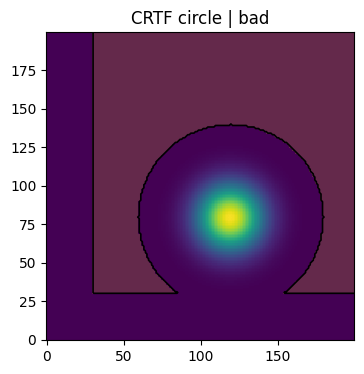

In [43]:
expr = "roi | bad"
mask_expr = select_mask(da, select=expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_mask(ax, da, mask_expr, "CRTF circle | bad")
plt.show()

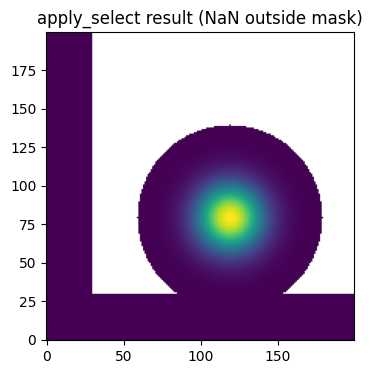

In [44]:
sel_expr = apply_select(da, select=mask_expr, mask_source=mask_source)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(sel_expr, origin="lower")
ax.set_title("apply_select result (NaN outside mask)")
plt.show()